In [1]:
from tqdm import tqdm
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
import re

import pandas as pd
import numpy as np
from collections import Counter

In [2]:
with open('Стихотворения, Библиотека литературы Древней Руси. Том 18.html', 'r', encoding='utf8') as f:
    page = f.read()
soup = BeautifulSoup(page, 'html.parser')

In [3]:
soup = soup.find(id="2_2").parent

In [4]:
poems = {}
one_poem = []
poem_name = ''
c = 0
for i in tqdm(soup.descendants):
    if i.text == '* * *':
        poems[poem_name] = one_poem
        one_poem = []
        poem_name = 'стих' + str(c)
    elif i.name == 'h2':
        poems[poem_name] = one_poem
        one_poem = []
        poem_name = i.text
    elif i.name == "p":
        one_poem.append(i.text)

43151it [00:00, 282003.90it/s]


In [5]:
def count_voices(verse):
    voices = 'аоуэыяёюеи'
    syllabs = []
    one_word_syllabs = 0
    verse = verse.lower()
    for letter in verse:
        if letter in voices:
            one_word_syllabs += 1
        elif letter in ' ?><.,:;!':
            syllabs.append(one_word_syllabs)
    syllabs.append(one_word_syllabs)
    result = []
    for i in syllabs:
        if i not in result:
            result.append(i)
    return [i for i in result if i != 0]

In [6]:
count_voices('Сокруши кости мои верою моею,')

[3, 5, 7, 10, 13]

In [7]:
names = []
verses = []
count_syllabs = []
syllabs_order = []
is_true_syllabic = []
for key, value in poems.items():
    if value != []:
        one_verse_syllabs = []
        for verse in value:
            if len(verse) > 5:
                if count_voices(verse)[-1] < 30:
                    names.append(key.strip())
                    verses.append(verse.strip())
                    count_syllabs.append(count_voices(verse)[-1])
                    syllabs_order.append(count_voices(verse)[:-1])
                    one_verse_syllabs.append(count_voices(verse)[-1])
        if len(set(one_verse_syllabs)) == 1:
            for verse in value:
                if len(verse) > 5:
                    if count_voices(verse)[-1] < 30:
                        is_true_syllabic.append(True)
        else:
            for verse in value:
                if len(verse) > 5:
                    if count_voices(verse)[-1] < 30:
                        is_true_syllabic.append(False)

In [8]:
Counter(is_true_syllabic)

Counter({False: 9541, True: 1463})

In [9]:
done = []
is_syll = []
for i, el in enumerate(names):
    if el not in done:
        done.append(el)
        is_syll.append(is_true_syllabic[i])
Counter(is_syll)

Counter({False: 173, True: 90})

In [10]:
data = pd.DataFrame()
data['verse'] = verses
data['poem_name'] = names
data['count_syllabs'] = count_syllabs
data['syllabs_order'] = syllabs_order
data['is_true_syllabic'] = is_true_syllabic
data

,verse,poem_name,count_syllabs,syllabs_order,is_true_syllabic
0,(Предисловие к Азбуковнику)1,Евстратий,10,[5],False
1,"Единому Богу в Троицы, Славимому в Единицы;",Евстратий,17,"[4, 6, 9, 13]",False
2,"Безначальному Отцу, Без отца, без матери нерож...",Евстратий,18,"[5, 7, 8, 10, 11, 14]",False
3,"Сыну, сначальному Отцу,От Отца без матери поро...",Евстратий,19,"[2, 6, 8, 9, 11, 12, 15]",False
4,"Отчю же и Сыновину, Духу животворящу,Богу равн...",Евстратий,22,"[2, 3, 4, 8, 10, 15, 17]",False
...,...,...,...,...,...
10999,и введи на радость в Яерусалим горний.,Седмь грехов главнейших1286,13,"[1, 3, 4, 6, 11]",False
11000,"Сердце мое, многими грехми отягченно,",Седмь грехов главнейших1286,13,"[2, 4, 7, 9]",False
11001,"сотвори на похвалу себе сокрушенно,",Седмь грехов главнейших1286,13,"[3, 4, 7, 9]",False
11002,"Да тя чистим, Владыко, должно величаю",Седмь грехов главнейших1286,13,"[1, 2, 4, 7, 9]",False


In [18]:
data.to_csv('data.tsv', sep='\t')

In [11]:
caesuras = []
for el in data['syllabs_order']:
    for a in el:
        caesuras.append(a)
count_caesuras = Counter(caesuras).most_common
count_caesuras

<bound method Counter.most_common of Counter({7: 7459, 5: 6978, 3: 5401, 2: 5131, 1: 4165, 9: 4023, 4: 3908, 8: 3857, 6: 2971, 10: 2461, 11: 1363, 12: 442, 13: 227, 14: 164, 15: 126, 16: 94, 17: 54, 18: 31, 19: 25, 20: 7, 21: 5, 22: 3, 24: 1, 25: 1})>

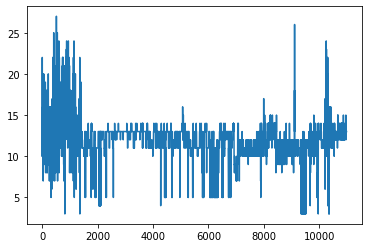

In [17]:
from matplotlib import pyplot as plt
plt.plot([i for i in data['count_syllabs'] if i < 30 and i > 2])

<AxesSubplot:xlabel='count_syllabs', ylabel='Count'>

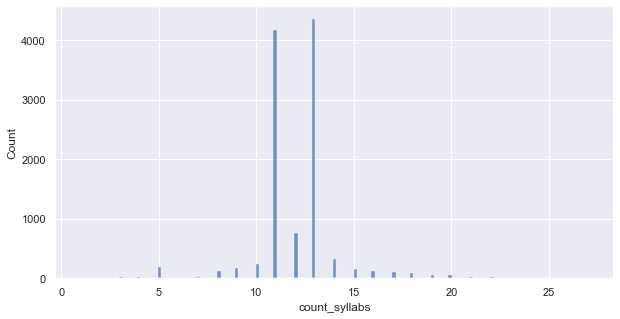

In [ ]:
from matplotlib import pyplot as plt
#plt.figure(figsize=(8,8))
#plt.hist([i for i in sorted(data['count_syllabs']) if i < 30 and i > 2])
#plt.legend()
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.histplot(data=data['count_syllabs'])

In [13]:
poems

{'': [],
 'Евстратий\n': ['(Предисловие к Азбуковнику)1',
  'Единому Богу в Троицы, Славимому в Единицы;',
  'Безначальному Отцу, Без отца, без матери нерожденну,',
  'Сыну, сначальному Отцу,От Отца без матери порожденну;',
  'Отчю же и Сыновину, Духу животворящу,Богу равнопрестольну,',
  'Святому всесвятящу; Богу в Бозе,  Свету от света,',
  'В простом слозе В вечныя лета Воспевание и слава,',
  'Честь, поклонение, Величание, держава,',
  'Благодарение, Благословившему начати Сей Алфовит',
  'И способившему скончати И сословит.'],
 'Иван Хворостинин2\n': [],
 'Изложение на еретики-злохульники \n': [],
 'Молитва\n': ['Призри на мя, Боже, в сиа времена',
  'И да смирятся гордости моей рамена3.',
  'Ты моя сила, мое и ограждение,',
  'Ты крепость моя и утвержение.',
  'Аз создание руку твоею,',
  'Сокруши кости мои верою моею,',
  'Да не скоростна будет ко греху душа моя',
  'И да пребудет во мне благодать твоя.',
  'Аз от утробы матере моея к тебе привержен,',
  'Да не будет ум мой от б

In [87]:
thirdsyl = data[data['count_syllabs'] == 13]
thirdsyl.reset_index(drop=True, inplace=True)
thirdsyl

,verse,poem_name,count_syllabs,syllabs_order,is_true_syllabic
0,И способившему скончати И сословит.,Евстратий,13,"[1, 6, 9, 10]",False
1,И да смирятся гордости моей рамена3.,Молитва,13,"[1, 2, 5, 8, 10]",False
2,"Ты моя сила, мое и ограждение,",Молитва,13,"[1, 3, 5, 7, 8]",False
3,"Сокруши кости мои верою моею,",Молитва,13,"[3, 5, 7, 10]",False
4,Спаси милостию своею моя уды,Молитва,13,"[2, 6, 9, 11]",False
...,...,...,...,...,...
4341,и введи на радость в Яерусалим горний.,Седмь грехов главнейших1286,13,"[1, 3, 4, 6, 11]",False
4342,"Сердце мое, многими грехми отягченно,",Седмь грехов главнейших1286,13,"[2, 4, 7, 9]",False
4343,"сотвори на похвалу себе сокрушенно,",Седмь грехов главнейших1286,13,"[3, 4, 7, 9]",False
4344,"Да тя чистим, Владыко, должно величаю",Седмь грехов главнейших1286,13,"[1, 2, 4, 7, 9]",False


In [111]:
first_ceasuras = []
for i, el in enumerate(list(thirdsyl['syllabs_order'])):
    if 1 in el:
        first_ceasuras.append(thirdsyl['verse'][i])

In [112]:
first_ceasuras

['И способившему скончати И сословит.',
 'И да смирятся гордости моей рамена3.',
 'Ты моя сила, мое и ограждение,',
 'Но не остави милости своей точию5,',
 'И будеши милостивен своему рабу.',
 'Не дай врагом вознестися злостию на ны,',
 'А злостныя да не будут на нас их раны.',
 'Но из Адама два естества именуют,',
 'О божественней славе радети не хотят.',
 'И повелевают держати свою веру,',
 'И послушанием оного почитати.',
 'Да того ради нас за Христа избивают,',
 'Во благочестивой вере утвержаемся.',
 'И леность неправедных скоро погибает.',
 'И доброту Христову в сердцы своем нуди.',
 'Да бых к противному от него не отступил,',
 'Но, любимии друзи, все благоверныя,',
 'Не напивайтеся от горкаго студенца29,',
 'Ни Платон, ни Пифагор, ниже Аристотель –',
 'И безумную ересь в себе полагают.',
 'Из Иерусалима в Византию дойде',
 'И во зловерии бесовском ослеплены,',
 'И ныне хвалится полунощная страна,',
 'И Богови служиши чистыми жертвами.',
 'Не наши суть пастыри западныя отцы,',
 'Н

In [109]:
Counter(first_ceasuras).most_common

<bound method Counter.most_common of Counter({'и': 329, 'да': 136, 'но': 114, 'а': 98, 'не': 85, 'от': 76, 'о': 60, 'на': 56, 'во': 38, 'за': 34, 'он': 25, 'по': 25, 'то': 22, 'ты': 20, 'в': 17, 'о,': 17, 'вся': 15, 'ни': 13, 'аз': 13, 'что': 13, 'бог': 11, 'кто': 10, 'царь': 10, 'глас': 10, 'ту': 9, 'вси': 9, 'и,': 9, 'но,': 8, 'из': 8, 'се': 8, 'зде': 7, 'той': 7, 'где': 7, 'несть': 7, 'ко': 7, 'тем': 7, 'сам': 6, 'сей': 6, 'царь,': 6, 'та': 6, 'со': 6, 'без': 6, 'днесь': 6, 'ты,': 5, 'мы': 5, 'даждь': 5, '«о': 4, 'дал': 4, 'князь': 4, 'пред': 4, 'жид': 4, 'есть': 3, 'у': 3, 'мир': 3, 'брат': 3, 'да,': 3, 'сын': 3, 'грех': 3, 'аз,': 3, 'муж': 3, 'коль': 3, 'дух': 3, 'все': 3, 'весть': 3, 'до': 3, 'виждь': 3, 'вы': 3, 'мой': 2, 'огнь': 2, 'як': 2, 'взем': 2, 'соль': 2, '«се': 2, 'к': 2, '«что': 2, 'весь': 2, 'мы,': 2, '«о,': 2, 'казнь': 2, 'ят': 2, 'жаль': 2, '«сей': 2, 'скорбь': 2, 'под': 2, 'жезл': 2, 'две': 2, 'яд': 2, 'знай': 2, 'чрез': 2, 'вся,': 2, 'век': 2, 'зри': 2, 'свет': 2,

In [110]:
Counter(caesuras_thirdsyl).most_common

<bound method Counter.most_common of Counter({7: 4210, 9: 2459, 4: 2122, 2: 2030, 3: 2011, 5: 1968, 10: 1839, 1: 1664, 8: 1236, 11: 963, 6: 549, 12: 142})>

In [88]:
elevensyl = data[data['count_syllabs'] == 11]
elevensyl.reset_index(drop=True, inplace=True)
elevensyl

,verse,poem_name,count_syllabs,syllabs_order,is_true_syllabic
0,"Призри на мя, Боже, в сиа времена",Молитва,11,"[2, 3, 4, 6, 8]",False
1,Ты крепость моя и утвержение.,Молитва,11,"[1, 3, 5, 6]",False
2,Благодать сотвори по судбам твоим,Молитва,11,"[3, 6, 7, 9]",False
3,"И дай к подвигом бодрость костем моим,",Молитва,11,"[1, 2, 5, 7, 9]",False
4,Сподоби ны со избранными стати,Молитва,11,"[3, 4, 5, 9]",False
...,...,...,...,...,...
4168,и лакомствы си насыщающися?,О смерти1228,11,"[1, 4, 5]",False
4169,"Вси от тебе, смерте, потребишася",О смерти1228,11,"[1, 2, 4, 6]",False
4170,во вечное молчание одееш.,О смерти1228,11,"[1, 4, 8]",False
4171,"Несть тебе потребно воздыхание,",О смерти1228,11,"[1, 3, 6]",False


In [89]:
caesuras_elevensyl = []
for el in elevensyl['syllabs_order']:
    for a in el:
        caesuras_elevensyl.append(a)
#count_caesuras = Counter(caesuras).most_common
#count_caesuras

In [90]:
caesuras_thirdsyl = []
for el in thirdsyl['syllabs_order']:
    for a in el:
        caesuras_thirdsyl.append(a)

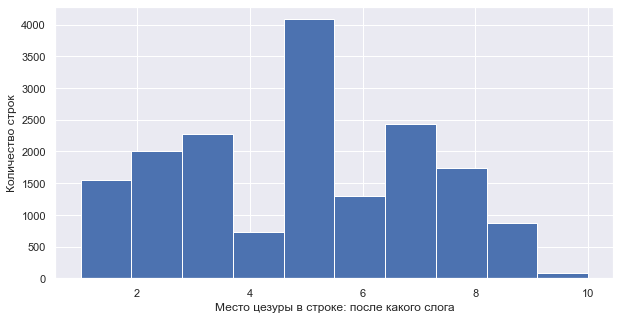

In [96]:
#sns.set(rc={'figure.figsize':(10,5)})
#sns.histplot(data=caesuras_elevensyl)
plt.hist(caesuras_elevensyl)
plt.xlabel("Место цезуры в строке: после какого слога")
plt.ylabel("Количество строк")
plt.show()

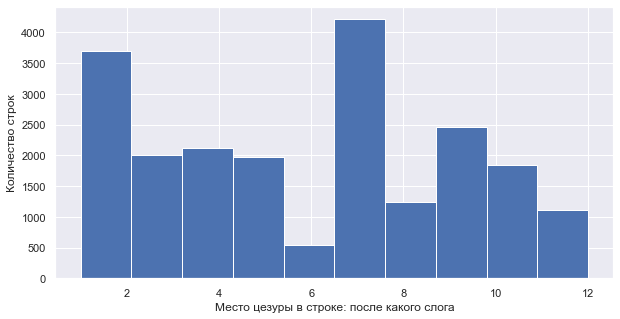

In [97]:
#sns.set(rc={'figure.figsize':(10,5)})
plt.hist(caesuras_thirdsyl)
plt.xlabel("Место цезуры в строке: после какого слога")
plt.ylabel("Количество строк")
plt.show()

In [50]:
authors = {}
one_author = []
author = ''
for key in poems.keys():
    if poems[key] == []:
        authors[author] = one_author
        author = key
        one_author = []
    else:
        one_author.append(key)

In [51]:
authors

{'': ['Евстратий\n'],
 'Иван Хворостинин2\n': [],
 'Изложение на еретики-злохульники \n': ['Молитва\n',
  'Молитва Христу Богу,\n',
  'О гонении на  Святую церковь, Краеграние14 сие по буквам \n',
  'Двоестрочное согласие вместо предисловия44 к читателю \n'],
 'Справщик Савватий65\n': ['Наставления ученику66 (князю Михаилу Никитичу Одоевскому)\n',
  'Алексей Романчуков100\n',
  'Нафанаил112\n',
  'Мартирий\n',
  'Мардарий\n'],
 'Михаил Злобин117\n': ['Прошение Михалка Злобина118\n',
  'Ино ко иному о щедротстве124 \n'],
 'Ларион\n': ['Послание к  Феоктисту133\n'],
 'Феоктист\n': ['От Феоктиста к Лариону старцу отвещание135\n'],
 'Федор Шелешпанский145\n': ['Послание князю С.И. Шаховскому\n'],
 'Алексей Онуфриев157\n': ['Стихи двоестрочни о книзе сей, образу Спасову благодарни и Богородице молебни, от черленых158 слов имущи разум некаков\n',
  'Стихи Кресту Господню похвални двоестрочни\n',
  'Ини стихи Всечестному и Животворящему Кресту Господню изяснители, благодарни, молебни, двоестр